# Patinaje sobre barra
El problema que hemos estado resolviendo en la lección anterior puede parecer un problema de juguete, que en realidad no es aplicable a escenarios de la vida real. Este no es el caso, porque muchos problemas del mundo real también comparten este escenario, incluido jugar al ajedrez o al go. Son similares, porque también tenemos un tablero con reglas dadas y un estado discreto .

## Introducción
En esta lección aplicaremos los mismos principios de Q-Learning a un problema con estado continuo , es decir, un estado dado por uno o más números reales. Nos ocuparemos del siguiente problema:

> Problema : si Peter quiere escapar del lobo, necesita poder moverse más rápido. Veremos cómo Peter puede aprender a patinar, en particular a mantener el equilibrio, utilizando Q-Learning.

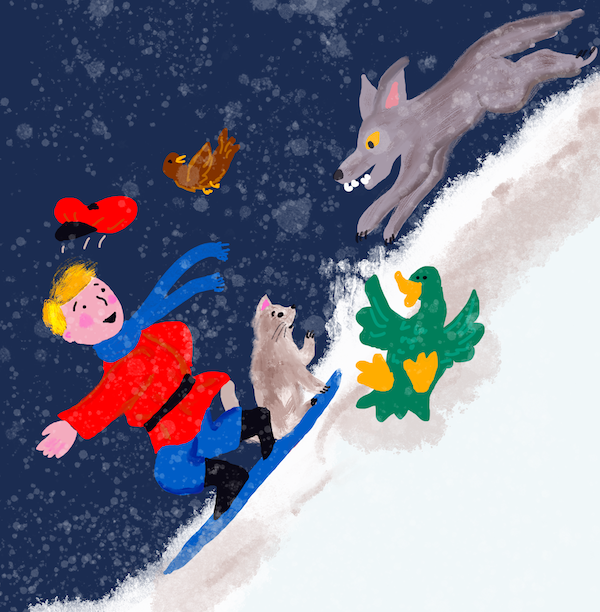

> ¡Peter y sus amigos se vuelven creativos para escapar del lobo! Imagen de Jen Looper

Usaremos una versión simplificada del equilibrio conocida como problema CartPole . En el mundo de los postes, tenemos un control deslizante horizontal que se puede mover hacia la izquierda o hacia la derecha, y el objetivo es equilibrar un poste vertical encima del control deslizante.

### Gimnasio OpenAI
En la lección anterior, las reglas del juego y el estado las dio la Boardclase que nosotros mismos definimos. Aquí usaremos un entorno de simulación especial , que simulará la física detrás del poste de equilibrio. Uno de los entornos de simulación más populares para entrenar algoritmos de aprendizaje por refuerzo se llama [Gimnasio](https://gym.openai.com/) , mantenido por [OpenAI](https://openai.com/) . Al utilizar este gimnasio podemos crear diferentes entornos, desde una simulación de cartpole hasta juegos de Atari.

> Nota : Puedes ver otros entornos disponibles en OpenAI Gym aquí .

Primero, instalemos el gimnasio e importemos las bibliotecas necesarias (bloque de código 1):

In [1]:
import sys
!{sys.executable} -m pip install gym 

import gym
import matplotlib.pyplot as plt
import numpy as np
import random

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


## Ejercicio: inicializar un entorno cartpole
Para trabajar con un problema de equilibrio de postes, necesitamos inicializar el entorno correspondiente. Cada entorno está asociado a un:

* **Espacio de observación** que define la estructura de la información que recibimos del entorno. Para el problema del poste, recibimos la posición del poste, la velocidad y algunos otros valores.

* **Espacio de acción** que define posibles acciones. En nuestro caso, el espacio de acción es discreto y consta de dos acciones: izquierda y derecha . (bloque de código 2)

1. Para iniciar, escriba el siguiente código:

In [2]:
env = gym.make("CartPole-v1")
print(env.action_space)
print(env.observation_space)
print(env.action_space.sample())

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
0


Para ver cómo funciona el entorno, ejecutemos una breve simulación de 100 pasos. En cada paso, proporcionamos una de las acciones a realizar; en esta simulación simplemente seleccionamos aleatoriamente una acción `action_space`.

2. Ejecute el siguiente código y vea a qué conduce.

✅ ¡Recuerde que es preferible ejecutar este código en una instalación local de Python! (bloque de código 3)

In [3]:
env.reset()

for i in range(100):
   env.render()
   env.step(env.action_space.sample())
env.close()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2. Durante la simulación, necesitamos obtener observaciones para decidir cómo actuar. De hecho, la función de paso devuelve observaciones actuales, una función de recompensa y el indicador de finalización que indica si tiene sentido continuar con la simulación o no: (bloque de código 4)

In [4]:
env.reset()

done = False
while not done:
   env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   print(f"{obs} -> {rew}")
env.close()

[ 0.03044442 -0.19543914 -0.04496216  0.28125618] -> 1.0
[ 0.02653564 -0.38989186 -0.03933704  0.55942606] -> 1.0
[ 0.0187378  -0.19424049 -0.02814852  0.25461393] -> 1.0
[ 0.01485299 -0.38894946 -0.02305624  0.53828712] -> 1.0
[ 0.007074   -0.19351108 -0.0122905   0.23842953] -> 1.0
[ 0.00320378  0.00178427 -0.00752191 -0.05810469] -> 1.0
[ 0.00323946  0.19701326 -0.008684   -0.35315131] -> 1.0
[ 0.00717973  0.00201587 -0.01574703 -0.06321931] -> 1.0
[ 0.00722005  0.19736001 -0.01701141 -0.36082863] -> 1.0
[ 0.01116725  0.39271958 -0.02422798 -0.65882671] -> 1.0
[ 0.01902164  0.19794307 -0.03740452 -0.37387001] -> 1.0
[ 0.0229805   0.39357584 -0.04488192 -0.67810827] -> 1.0
[ 0.03085202  0.58929164 -0.05844408 -0.98457719] -> 1.0
[ 0.04263785  0.78514572 -0.07813563 -1.2950295 ] -> 1.0
[ 0.05834076  0.98116859 -0.10403622 -1.61111521] -> 1.0
[ 0.07796413  0.78741784 -0.13625852 -1.35259196] -> 1.0
[ 0.09371249  0.98396202 -0.16331036 -1.68461179] -> 1.0
[ 0.11339173  0.79106371 -0.197

* El vector de observación que se devuelve en cada paso de la simulación contiene los siguientes valores:

    * Posición del carro
    * Velocidad del carro
    * Ángulo del poste
    * Velocidad de rotación del polo
3. Obtenga el valor mínimo y máximo de esos números: (bloque de código 5)

In [5]:
print(env.observation_space.low)
print(env.observation_space.high)

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


### Discretización del estado
En Q-Learning, necesitamos crear Q-Table que defina qué hacer en cada estado. Para poder hacer esto, necesitamos que el estado sea discreto ; más precisamente, debe contener un número finito de valores discretos. Por lo tanto, necesitamos de alguna manera discretizar nuestras observaciones, mapeándolas a un conjunto finito de estados.

Hay algunas maneras en que podemos hacer esto:

* Dividir en contenedores . Si conocemos el intervalo de un determinado valor, podemos dividir este intervalo en varios contenedores y luego reemplazar el valor por el número de contenedor al que pertenece. Esto se puede hacer usando el digitizemétodo numpy. En este caso sabremos con precisión el tamaño del estado, porque dependerá del número de bins que seleccionemos para la digitalización.
    
✅ Podemos usar la interpolación lineal para llevar valores a algún intervalo finito (digamos, de -20 a 20) y luego convertir números a enteros redondeándolos. Esto nos da un poco menos de control sobre el tamaño del estado, especialmente si no conocemos los rangos exactos de los valores de entrada. Por ejemplo, en nuestro caso, 2 de cada 4 valores no tienen límites superior/inferior en sus valores, lo que puede resultar en un número infinito de estados.

En nuestro ejemplo, optaremos por el segundo enfoque. Como podrá observar más adelante, a pesar de los límites superior/inferior no definidos, esos valores rara vez toman valores fuera de ciertos intervalos finitos, por lo que aquellos estados con valores extremos serán muy raros.

1. Aquí está la función que tomará la observación de nuestro modelo y producirá una tupla de 4 valores enteros: (bloque de código 6)

In [6]:
def discretize(x):
    return tuple((x/np.array([0.25, 0.25, 0.01, 0.1])).astype(np.int))

2. Exploremos también otro método de discretización usando bins: (bloque de código 7)

In [7]:
def create_bins(i,num):
    return np.arange(num+1)*(i[1]-i[0])/num+i[0]

print("Sample bins for interval (-5,5) with 10 bins\n",create_bins((-5,5),10))

ints = [(-5,5),(-2,2),(-0.5,0.5),(-2,2)] # intervals of values for each parameter
nbins = [20,20,10,10] # number of bins for each parameter
bins = [create_bins(ints[i],nbins[i]) for i in range(4)]

def discretize_bins(x):
    return tuple(np.digitize(x[i],bins[i]) for i in range(4))

Sample bins for interval (-5,5) with 10 bins
 [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]


3. Ahora ejecutemos una breve simulación y observemos esos valores ambientales discretos. Siéntase libre de probar ambos `discretize` y `discretize_binsver` si hay alguna diferencia.

✅ `discretize_bins` devuelve el número de contenedor, que está basado en 0. Por lo tanto, para valores de la variable de entrada alrededor de 0, devuelve el número de la mitad del intervalo (10). En discretizar, no nos importaba el rango de valores de salida, permitiéndoles ser negativos, por lo tanto los valores de estado no se desplazan y 0 corresponde a 0. (bloque de código 8)

In [8]:
env.reset()

done = False
while not done:
   #env.render()
   obs, rew, done, info = env.step(env.action_space.sample())
   #print(discretize_bins(obs))
   print(discretize(obs))
env.close()

(0, 0, -1, -3)
(0, 0, -2, 0)
(0, 0, -2, -3)
(0, 1, -3, -6)
(0, 2, -4, -9)
(0, 3, -6, -12)
(0, 2, -8, -9)
(0, 3, -10, -13)
(0, 4, -13, -16)
(0, 4, -16, -19)
(0, 4, -20, -17)
(0, 4, -24, -20)


✅ Descomente la línea que comienza con env.render si desea ver cómo se ejecuta el entorno. De lo contrario puedes ejecutarlo en segundo plano, lo cual es más rápido. Usaremos esta ejecución "invisible" durante nuestro proceso Q-Learning.

### La estructura de la Q-Table
En nuestra lección anterior, el estado era un par simple de números del 0 al 8 y, por lo tanto, era conveniente representar Q-Table mediante un tensor numpy con una forma de 8x8x2. Si usamos la discretización de bins, el tamaño de nuestro vector de estado también se conoce, por lo que podemos usar el mismo enfoque y representar el estado mediante una matriz de forma 20x20x10x10x2 (aquí 2 es la dimensión del espacio de acción, y las primeras dimensiones corresponden al número de bins que hemos seleccionado para usar para cada uno de los parámetros en el espacio de observación).

Sin embargo, a veces no se conocen las dimensiones exactas del espacio de observación. En el caso de la discretizefunción, es posible que nunca estemos seguros de que nuestro estado se mantenga dentro de ciertos límites, porque algunos de los valores originales no están limitados. Por lo tanto, utilizaremos un enfoque ligeramente diferente y representaremos Q-Table mediante un diccionario.

1. Utilice el par (estado, acción) como clave del diccionario y el valor corresponderá al valor de entrada de Q-Table. (bloque de código 9)

In [9]:
Q = {}
actions = (0,1)

def qvalues(state):
    return [Q.get((state,a),0) for a in actions]

Aquí también definimos una función qvalues(), que devuelve una lista de valores de Q-Table para un estado determinado que corresponde a todas las acciones posibles. Si la entrada no está presente en Q-Table, devolveremos 0 como valor predeterminado.

### Empecemos Q-Learning
¡Ahora estamos listos para enseñarle a Peter a mantener el equilibrio!

1. Primero, establezcamos algunos hiperparámetros: (bloque de código 10)

In [10]:
# hyperparameters
alpha = 0.3
gamma = 0.9
epsilon = 0.90

Aquí `alpha` está la tasa de aprendizaje que define hasta qué punto debemos ajustar los valores actuales de Q-Table en cada paso. En la lección anterior comenzamos con 1 y luego disminuimos  `alpha` a valores más bajos durante el entrenamiento. En este ejemplo lo mantendremos constante solo por simplicidad y podrás experimentar ajustando `alpha` los valores más adelante.

`gamma` es el factor de descuento que muestra hasta qué punto debemos priorizar la recompensa futura sobre la recompensa actual.

`epsilon` es el factor exploración/explotación que determina si debemos preferir la exploración a la explotación o viceversa. En nuestro algoritmo, en `epsilon` un porcentaje de los casos seleccionaremos la siguiente acción de acuerdo con los valores de Q-Table, y en el número restante de casos ejecutaremos una acción aleatoria. Esto nos permitirá explorar áreas del espacio de búsqueda que nunca antes habíamos visto.

✅ En términos de equilibrio, elegir una acción aleatoria (exploración) actuaría como un golpe aleatorio en la dirección equivocada, y el poste tendría que aprender a recuperar el equilibrio de esos "errores".

### Mejorar el algoritmo
También podemos hacer dos mejoras a nuestro algoritmo de la lección anterior:

Calcule la recompensa acumulada promedio en varias simulaciones. Imprimiremos el progreso cada 5000 iteraciones y promediaremos nuestra recompensa acumulada durante ese período de tiempo. Esto significa que si obtenemos más de 195 puntos, podemos considerar el problema resuelto, incluso con una calidad superior a la requerida.

Calcule el resultado acumulado promedio máximo , `Qmax` y almacenaremos la Q-Table correspondiente a ese resultado. Cuando ejecute el entrenamiento, notará que a veces el resultado acumulado promedio comienza a disminuir y queremos mantener los valores de Q-Table que corresponden al mejor modelo observado durante el entrenamiento.

Recoja todas las recompensas acumuladas en cada simulación en el `rewards` vector para seguir trazando. (bloque de código 11)

In [11]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Qmax = 0
cum_rewards = []
rewards = []
for epoch in range(100000):
    obs = env.reset()
    done = False
    cum_reward=0
    # == do the simulation ==
    while not done:
        s = discretize(obs)
        if random.random()<epsilon:
            # exploitation - chose the action according to Q-Table probabilities
            v = probs(np.array(qvalues(s)))
            a = random.choices(actions,weights=v)[0]
        else:
            # exploration - randomly chose the action
            a = np.random.randint(env.action_space.n)

        obs, rew, done, info = env.step(a)
        cum_reward+=rew
        ns = discretize(obs)
        Q[(s,a)] = (1 - alpha) * Q.get((s,a),0) + alpha * (rew + gamma * max(qvalues(ns)))
    cum_rewards.append(cum_reward)
    rewards.append(cum_reward)
    # == Periodically print results and calculate average reward ==
    if epoch%5000==0:
        print(f"{epoch}: {np.average(cum_rewards)}, alpha={alpha}, epsilon={epsilon}")
        if np.average(cum_rewards) > Qmax:
            Qmax = np.average(cum_rewards)
            Qbest = Q
        cum_rewards=[]

0: 108.0, alpha=0.3, epsilon=0.9


Lo que puede notar en esos resultados:

* **Cerca de nuestra meta**. Estamos muy cerca de lograr el objetivo de obtener 195 recompensas acumuladas en más de 100 ejecuciones consecutivas de la simulación, ¡o es posible que realmente lo hayamos logrado! Incluso si obtenemos números más pequeños, todavía no lo sabemos, porque tenemos un promedio de más de 5000 ejecuciones, y sólo se requieren 100 ejecuciones en los criterios formales.

* **La recompensa comienza a caer**. A veces la recompensa comienza a caer, lo que significa que podemos "destruir" valores ya aprendidos en la Q-Table con aquellos que empeoran la situación.

Esta observación es más claramente visible si trazamos el progreso del entrenamiento.

### Trazar el progreso del entrenamiento
Durante el entrenamiento, recopilamos el valor de recompensa acumulativo en cada una de las iteraciones del rewardsvector. Así es como se ve cuando lo trazamos con respecto al número de iteración:

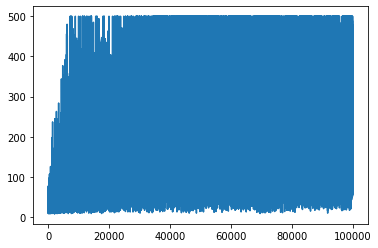

In [20]:
plt.plot(rewards)

A partir de este gráfico, no es posible decir nada porque, debido a la naturaleza del proceso de entrenamiento estocástico, la duración de las sesiones de entrenamiento varía mucho. Para que este gráfico tenga más sentido, podemos calcular el promedio móvil de una serie de experimentos, digamos 100. Esto se puede hacer convenientemente usando `np.convolve`: (bloque de código 12)

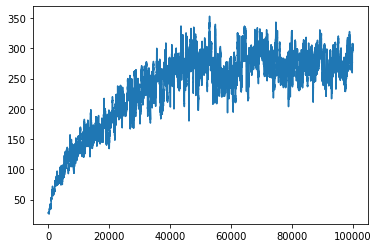

In [22]:
def running_average(x,window):
    return np.convolve(x,np.ones(window)/window,mode='valid')

plt.plot(running_average(rewards,100))

### Hiperparámetros variables
Para que el aprendizaje sea más estable, tiene sentido ajustar algunos de nuestros hiperparámetros durante el entrenamiento. En particular:

Para la tasa de aprendizaje , alphapodemos comenzar con valores cercanos a 1 y luego seguir disminuyendo el parámetro. Con el tiempo, obtendremos buenos valores de probabilidad en la Q-Table y, por lo tanto, deberíamos ajustarlos ligeramente y no sobrescribirlos completamente con valores nuevos.

Aumentar épsilon . Es posible que queramos aumentarlo epsilonlentamente para explorar menos y explotar más. Probablemente tenga sentido comenzar con un valor más bajo de epsilony subir hasta casi 1.

> Tarea 1 : juegue con valores de hiperparámetros y vea si puede lograr una recompensa acumulativa más alta. ¿Estás por encima de 195?

> Tarea 2 : para resolver formalmente el problema, debes obtener una recompensa promedio de 195 en 100 ejecuciones consecutivas. ¡Mídelo durante el entrenamiento y asegúrate de haber resuelto formalmente el problema!

### Ver el resultado en acción
Sería interesante ver cómo se comporta el modelo entrenado. Ejecutemos la simulación y sigamos la misma estrategia de selección de acciones que durante el entrenamiento, muestreando de acuerdo con la distribución de probabilidad en Q-Table: (bloque de código 13)

In [23]:
obs = env.reset()
done = False
while not done:
   s = discretize(obs)
   env.render()
   v = probs(np.array(qvalues(s)))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
env.close()


## Guardar el resultado en un GIF animado

Si desea impresionar a sus amigos, es posible que desee enviarles la imagen GIF animada del poste de equilibrio. Para hacer esto, podemos invocar 'env.render' para producir un marco de imagen y luego guardarlos en GIF animados usando la biblioteca PIL:

In [26]:
from PIL import Image
obs = env.reset()
done = False
i=0
ims = []
while not done:
   s = discretize(obs)
   img=env.render(mode='rgb_array')
   ims.append(Image.fromarray(img))
   v = probs(np.array([Qbest.get((s,a),0) for a in actions]))
   a = random.choices(actions,weights=v)[0]
   obs,_,done,_ = env.step(a)
   i+=1
env.close()
ims[0].save('images/cartpole-balance.gif',save_all=True,append_images=ims[1::2],loop=0,duration=5)
print(i)

360


## Conclusión
Ahora hemos aprendido cómo entrenar agentes para lograr buenos resultados simplemente proporcionándoles una función de recompensa que defina el estado deseado del juego y dándoles la oportunidad de explorar inteligentemente el espacio de búsqueda. Hemos aplicado con éxito el algoritmo Q-Learning en los casos de entornos discretos y continuos, pero con acciones discretas.

También es importante estudiar situaciones en las que el estado de acción también es continuo y cuando el espacio de observación es mucho más complejo, como la imagen de la pantalla del juego Atari. En esos problemas a menudo necesitamos utilizar técnicas de aprendizaje automático más potentes, como redes neuronales, para lograr buenos resultados. Esos temas más avanzados son el tema de nuestro próximo curso de IA más avanzado.